# Changing politics

"A week is a long time in politics."
How many times have we heard that aphorism?
That quality makes politics a prime case to test one of the most important tests for ATE: that it's useful in dynamic domains.

We need ATE because some domains are consistently changing and it's too expensive for humans to adapt our lexicons, literature goes.
The argument is sound, but it doesn't mean that ATE approaches fulfil the task.
This notebook examines how well different ATE methods adapt over three months of US politics.

First, we load all the necessary packages and specify the supporting data directories.

In [1]:
from datetime import datetime
import importlib
import json
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.patheffects as pe
import os
import pandas as pd
import sys
import re

sys.path.append(os.path.expanduser("~/GitHub/multiplex-plot"))
sys.path = list(set(sys.path))

from multiplex import drawable

resultsdir = os.path.expanduser('~/DATA/c4-ate/elections/analyses/progression-verified/results-states-new-ap')
datadir = os.path.expanduser('~/DATA/c4-ate/elections/analyses/progression-verified')

Next, we load all of the data.
To analyze progression, we apply each method from day 1 until day _n_.

In [2]:
# create the dataframe
df = pd.DataFrame(columns=[ 'method', 'events', 'ap', 'precision', 'recall', 'f1', 'terms' ])

files = os.listdir(resultsdir) # the evaluation files
pattern = re.compile("([a-z\-]+)-([0-9]+).json") # the extraction pattern (to get the number of events used to extract terms)

for file in files:
    with open(os.path.join(resultsdir, file)) as f:
        results = json.loads(f.readline())
        method, events = pattern.findall(file)[0]
        
        # get the summary results
        summary = results['results']['summary']
        
        # get the terms
        terms = results['pcmd']['terms']
        
        df.loc[len(df)] = { 'method': method, 'events': int(events),
                            'ap': summary['average precision'], 'precision': summary['precision'],
                            'recall': summary['recall'], 'f1': summary['f1'], 'terms': terms }

df = df.sort_values(by=['method', 'events'])
df = df.reset_index(drop=True)
df.head()

,method,events,ap,precision,recall,f1,terms
0,ef-idf-entropy,2,0.007228,0.205,0.033856,0.058115,"[kazakhstan, defector, cooney, pipelin, pennsy..."
1,ef-idf-entropy,3,0.007600,0.205,0.033856,0.058115,"[lesley, stahl, hunter, laptop, ralli, cooney,..."
2,ef-idf-entropy,4,0.007575,0.210,0.034682,0.059532,"[hunter, laptop, lesley, stahl, giuliani, land..."
3,ef-idf-entropy,5,0.007338,0.195,0.032205,0.055280,"[lesley, hunter, laptop, stahl, giuliani, harr..."
4,ef-idf-entropy,6,0.008183,0.200,0.033031,0.056697,"[hunter, lesley, laptop, landslid, ralli, harr..."


To give some more context to the changing performance, we load the dates in the dataset.
Between 12 January and 14 January 2021, we did not collect any data.

In [3]:
files = os.listdir(datadir)
date_pattern = re.compile("([0-9]+).json")
with open(os.path.join(datadir, f"ef-idf-entropy-{ df.events.max() }.json")) as f:
    results = json.loads(f.readline())
    files = results['cmd']['files']
    files.extend([ f"202101{ d }.json" for d in range(12, 15) ])
    dates = [ date_pattern.findall(file)[0] for file in files ]
    dates = [ datetime.strptime(date, "%Y%m%d") for date in dates ]

dates = sorted(dates)

In the datasets too, we create a space where there is a gap in the data.

In [4]:
df.events = pd.to_numeric(df.events)
df.events = [ events + 3 if events > df.events.max() - 7 else events
                         for events in df.events ]
df.head()

,method,events,ap,precision,recall,f1,terms
0,ef-idf-entropy,2,0.007228,0.205,0.033856,0.058115,"[kazakhstan, defector, cooney, pipelin, pennsy..."
1,ef-idf-entropy,3,0.007600,0.205,0.033856,0.058115,"[lesley, stahl, hunter, laptop, ralli, cooney,..."
2,ef-idf-entropy,4,0.007575,0.210,0.034682,0.059532,"[hunter, laptop, lesley, stahl, giuliani, land..."
3,ef-idf-entropy,5,0.007338,0.195,0.032205,0.055280,"[lesley, hunter, laptop, stahl, giuliani, harr..."
4,ef-idf-entropy,6,0.008183,0.200,0.033031,0.056697,"[hunter, lesley, laptop, landslid, ralli, harr..."


## Changing landscape, changing terms

The 2020 US elections were spectacular.
Set in the backdrop of the COVID-19 pandemic, Americans elected Joe Biden as the new president, but they had to wait for days to learn of the election's outcome.
In the meantime, incumbent president Donald Trump cust doubt on the result, and continued doing so while the electoral college confirmed the vote.
The escalating tensions led to rioters storming the US capitol while Congress was certifying the vote.
Joe Biden was still inaugurated as president days later.

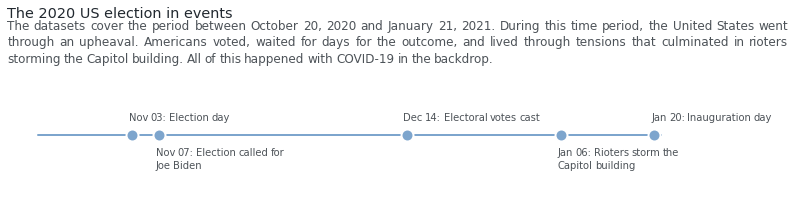

In [5]:
# create a style
plt.style.use(os.path.join(os.getcwd(), '../modern-custom.style'))
style = { 'linewidth': 2, 'with_legend': True,
          'path_effects': [ pe.Stroke(linewidth=6, foreground='C4'), pe.Normal() ] }
marker_style = { 'marker': 'o', 'markersize': 12, 
                 'markeredgewidth': 2, 'markeredgecolor': 'C4' }
line_style = { 'alpha': 0.3, 'linestyle': '--', 'linewidth': 1 }
annotation_style = { 'fontsize': 'smaller', 'alpha': 0.8, 'pad': 0,
                     'align': 'right', 'va': 'center', 'facecolor': '#ffffff99' }

# prepare the data
# annotations partially taken from CNN
# https://edition.cnn.com/2020/12/07/politics/electoral-college-vote-timeline/index.html
events = {
    'election': 15,
    'call': 19,
    'college': 56,
    'riot': 79,
    'inauguration': 93
}
annotations = {
    events['election']: "Election day",
    events['call']: "Election called for Joe Biden",
    events['college']: "Electoral votes cast",
    events['riot']: "Rioters storm the Capitol building",
    events['inauguration']: "Inauguration day"
}

# draw the visualization
figure = plt.figure(figsize=(14, 2.5))
viz = drawable.Drawable(figure)
viz.draw_time_series(range(1, df.events.max() + 1), [ 1 ] * df.events.max(), color='C1', **style)

# draw the annotations
_annotation_style = dict(annotation_style)
for i, (x, label) in enumerate(annotations.items()):
    viz.plot(x, 1, color='C1', **marker_style)
    _annotation_style['va'] = 'top' if i % 2 else 'bottom'
    _annotation_style['align'] = 'left'
    pos_x = (x - 0.5, x + 20)
    offset_y = 0.01 * (-1 if i % 2 else 1)
    viz.annotate(f"{ re.sub('^0', '', dates[x - 1].strftime('%b %d')) }: { label }",
                 pos_x, 1 + offset_y, **_annotation_style)

# finalize the plot
viz.axis(False)
xlim = viz.get_xlim()
viz.set_xlim(xlim[0], max(xlim[1], max(annotations) + 20))
viz.set_title("The 2020 US election in events", loc='left')
viz.set_caption(f"""The datasets cover the period between { re.sub('^0', '', dates[0].strftime("%B %d, %Y")) } and { re.sub('^0', '', dates[-1].strftime("%B %d, %Y")) }.
                    During this time period, the United States went through an upheaval.
                    Americans voted, waited for days for the outcome, and lived through tensions that culminated in rioters storming the Capitol building.
                    All of this happened with COVID-19 in the backdrop.""",
                align='justify')
viz.savefig('../exports/4.4-election-timeline.png', dpi=300, bbox_inches='tight')

The next visualization contrasts EF-ICF-Entropy with Rank Difference.
EF-ICF-Entropy's F-measure slumps after the election is called for Joe Biden, around a fortnight after data collection, but recovers and comfortably overtakes Rank Difference.
However, it takes almost a month to reach this level.

**Conclusion:** EF-ICF-Entropy takes longer to learn about dynamic domains than Rank Difference.

> Note: Before going any further, remember that EF-ICF-Entropy has a big disadvantage in this analysis.
        Unlike the rest of the methods, EF-ICF-Entropy is unaware of POS tagging, so its rankings invariably include more named entities than the other methods' rankings.

/home/nicholas/GitHub/multiplex-plot/multiplex/drawable.py:378: UserWarning: FixedFormatter should only be used together with FixedLocator
  return getattr(self.axes, name)(*args, **kwargs)
/home/nicholas/GitHub/multiplex-plot/multiplex/drawable.py:378: UserWarning: FixedFormatter should only be used together with FixedLocator
  return getattr(self.axes, name)(*args, **kwargs)


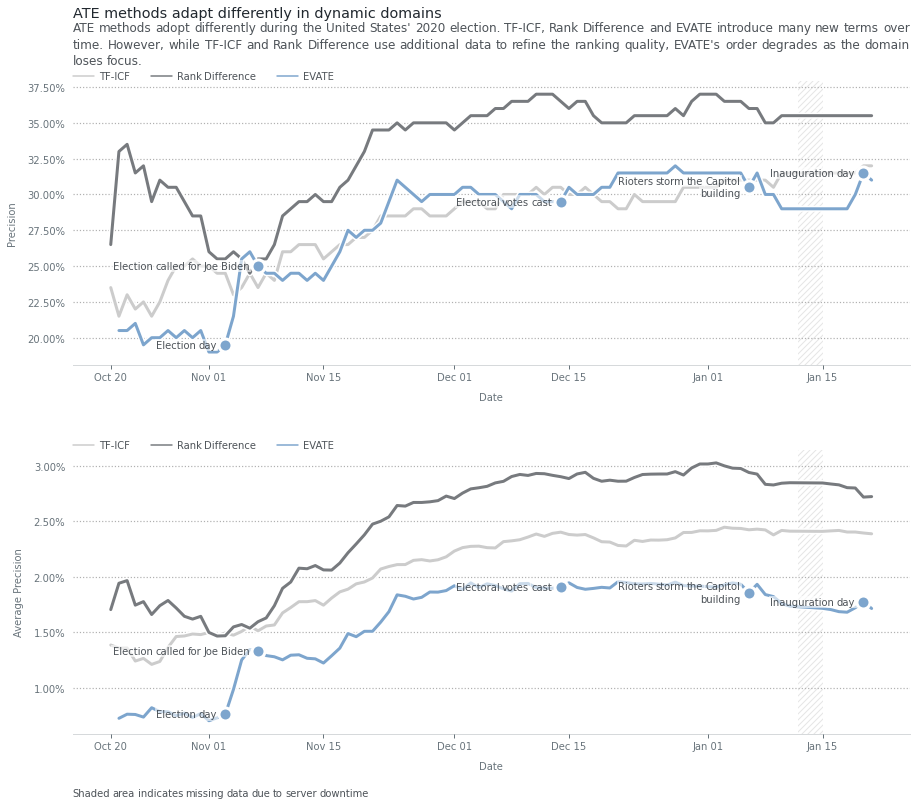

In [6]:
drawable = importlib.reload(drawable)

# create a style
plt.style.use(os.path.join(os.getcwd(), '../modern-custom.style'))
style = { 'linewidth': 3, 'with_legend': True, 'zorder': 1,
          'path_effects': [ pe.Stroke(linewidth=6, foreground='C4'), pe.Normal() ] }
marker_style = { 'marker': 'o', 'markersize': 9 }
scatter_style = { 's': marker_style['markersize'] ** 2, 'zorder': 2 }
annotation_marker_style = dict(marker_style)
annotation_marker_style.update({ 'markersize': 13, 'markeredgewidth': 3, 'markeredgecolor': 'C4' }) # 18-4=14 (markersize)
line_style = { 'alpha': 0.3, 'linestyle': '--', 'linewidth': 1 }
annotation_style = { 'align': 'right', 'fontsize': 'smaller',
                     'va': 'center', 'alpha': 0.8, 'facecolor': '#ffffff99' }

methods = { 'tf-idf-nva': 'TF-ICF',
            'rank-nva': 'Rank Difference',
            'ef-idf-entropy': 'EVATE' }
linestyle = { 'ef-idf-entropy': '-',
              'rank-nva': '-',
              'tf-idf-nva': '-' }
colors = { 'ef-idf-entropy': 'C1',
              'rank-nva': 'C3',
              'tf-idf-nva': 'C5' }

# set up the visualization
plt.style.use(os.path.join(os.getcwd(), '..', "modern-custom.style"))
plt.style.reload_library()
figure, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15,12))

# visualization 1

# prepare the data
metric = 'precision'

# draw the visualization
viz = drawable.Drawable(figure, ax1)
for method, name in methods.items():
    viz.draw_time_series(df[df.method == method].events, df[df.method == method][metric],
                         name, color=colors[method], linestyle=linestyle[method], **style)

# annotate
for x, label in annotations.items():
    y = df[(df.method == 'ef-idf-entropy') & (df.events == x) ][metric]
    viz.plot(x, y, color='C1', **annotation_marker_style)
    viz.annotate(label, (x - 20, x - 1), y, **annotation_style)

# gray out the portion without data
ylim = viz.get_ylim()
missing = [ i for i in range(df.events.min(), df.events.max()) if i not in df.events.to_list() ]
viz.add_patch(Polygon([ (min(missing), ylim[0]), (max(missing) + 1, ylim[0]),
                        (max(missing) + 1, ylim[1]), (min(missing), ylim[1]) ],
              hatch='////', fill=None, alpha=0.5, linewidth=0, edgecolor='C5', zorder=-1))    

# finalize the visualization
viz.set_xlabel('Date')
viz.set_ylabel('Precision')
xticks = list(set([ 1, 13, 27, 43, 57, 74, 88 ]))
viz.set_xticks(xticks)
viz.set_xticklabels([ re.sub('^0', '', dates[i - 1].strftime("%b %d")) for i in xticks ])
yticks = [ '{:.2f}%'.format(round(tick * 100, 4)) for tick in viz.get_yticks() ]
viz.set_yticklabels(yticks)
viz.set_axisbelow(True)
viz.set_title("ATE methods adapt differently in dynamic domains", loc='left')
viz.set_caption(f"""ATE methods adopt differently during the United States' 2020 election.
                    TF-ICF, Rank Difference and EVATE introduce many new terms over time.
                    However, while TF-ICF and Rank Difference use additional data to refine the ranking quality, EVATE's order degrades as the domain loses focus.""",
                align='justify')

# visualization 2

# prepare the data
metric = 'ap'

# draw the visualization
viz = drawable.Drawable(figure, ax2)
for method, name in methods.items():
    viz.draw_time_series(df[df.method == method].events, df[df.method == method][metric],
                         name, color=colors[method], linestyle=linestyle[method], **style)

# annotate
for x, label in annotations.items():
    y = df[(df.method == 'ef-idf-entropy') & (df.events == x) ][metric]
    viz.plot(x, y, color='C1', **annotation_marker_style)
    viz.annotate(label, (x - 20, x - 1), y, **annotation_style)

# gray out the portion without data
ylim = viz.get_ylim()
missing = [ i for i in range(df.events.min(), df.events.max()) if i not in df.events.to_list() ]
viz.add_patch(Polygon([ (min(missing), ylim[0]), (max(missing) + 1, ylim[0]),
                        (max(missing) + 1, ylim[1]), (min(missing), ylim[1]) ],
              hatch='////', fill=None, alpha=0.5, linewidth=0, edgecolor='C5', zorder=-1))    

# finalize the visualization
yticks = [ '{:.2f}%'.format(round(tick * 100, 4)) for tick in viz.get_yticks() ]
viz.set_xlabel('Date')
viz.set_ylabel('Average Precision')
viz.set_xticks(xticks)
viz.set_xticklabels([ re.sub('^0', '', dates[i - 1].strftime("%b %d")) for i in xticks ])
viz.set_yticklabels(yticks)
viz.set_axisbelow(True)
viz.set_footnote("Shaded area indicates missing data due to server downtime")

viz.savefig('../exports/4.4-dynamic-ap-precision.png', dpi=300, bbox_inches='tight')

The different fortunes between Rank Difference and EF-ICF-Entropy appear clearly and quickly.
Between October 21 and November 7, 2020, Rank Difference's precision tanks, while EF-ICF-Entropy's rises spectacularly.
However, in both cases, AP increases, with **EF-ICF-Entropy's AP plateauing early because of its high-ranked named entities**.

During this period, Rank Difference keeps refining its ranking, but it handles new terms relatively poorly.
In fact, over this period, both EF-ICF-Entropy and Rank Difference remove and add around the same number of terms to the lexicon.
However, while EF-ICF-Entropy adds many correct terms, Rank Difference removes many correct terms, like *poll*.

In [7]:
method, name = 'rank-nva', 'Rank Difference'
method, name = 'ef-idf-entropy', 'EVATE'
# method, name = 'tf-idf-nva', 'TF-ICF'
_df0 = df[(df.method == method) & (df.events == 2)].iloc[0]
# _df0 = df[(df.method == method) & (df.events == events['election'])].iloc[0]
_df1 = df[(df.method == method) & (df.events == events['call'])].iloc[0]

print(f"\033[1m{ name }\033[0m (beginning to election call)")
print()

movement = { term: _df0.terms.index(term) - _df1.terms.index(term) for term in _df0.terms if term in _df1.terms }
drops = sorted(movement, key=movement.get, reverse=False)
# print("\033[1mDrops\033[0m")
# for term in drops[:15]:
#     print(f"{ term }: { _df0.terms.index(term) + 1 } ⇒ { _df1.terms.index(term) + 1 } ({ movement[term] })")
# print()

lost = sorted([ term for term in _df0.terms if term not in _df1.terms ],
                   key=_df0.terms.index, reverse=False)
print(f"\033[1m{ len(lost) } lost\033[0m")
for term in lost[:10]:
    print(f"{ term }: { _df0.terms.index(term) + 1 }")
print('...')
for term in lost[-10:]:
    print(f"{ term }: { _df0.terms.index(term) + 1 }")
print()
    
risers = sorted(movement, key=movement.get, reverse=True)
# print("\033[1mRisers\033[0m")
# for term in risers[:10]:
#     print(f"{ term }: { _df0.terms.index(term) + 1 } ⇒ { _df1.terms.index(term) + 1 } ({ movement[term] })")
# print()

newcomers = sorted([ term for term in _df1.terms if term not in _df0.terms ],
                   key=_df1.terms.index, reverse=False)
print(f"\033[1m{ len(newcomers) } newcomers\033[0m")
for term in newcomers[:10]:
    print(f"{ term }: { _df1.terms.index(term) + 1 }")
print('...')
for term in newcomers[-10:]:
    print(f"{ term }: { _df1.terms.index(term) + 1 }")
print()

EVATE (beginning to election call)

113 lost
photo: 44
democrat: 45
elliott: 55
media: 56
guilti: 57
mute: 59
malaysian: 61
chairman: 62
bin: 63
raid: 64
...
nyt: 183
ban: 184
famiili: 189
threaten: 191
endanger: 193
agenc: 194
amtrak: 195
charter: 197
kill: 198
receiv: 199

113 newcomers
uselect: 9
elector: 19
bobulinski: 20
counti: 32
cnn: 33
delawar: 34
victori: 40
doj: 41
launder: 42
arizona: 43
...
judg: 187
legal: 188
cours: 189
project: 192
surpris: 195
activ: 196
super: 197
paid: 198
children: 199
process: 200



At this point, EF-ICF-Entropy had filled its top rankings with several names, like *Donald [Trump]* and *Joe [Biden]*, placing a relatively low ceiling on AP.

In [8]:
print(f"\033[1m{ name }\033[0m (beginning to election call)")
print()

for i, term in enumerate(_df1.terms[:20]):
    print(f"{ i + 1 }: { term }")

EVATE (beginning to election call)

1: hunter
2: fump
3: landslid
4: ralli
5: harri
6: pennsylvania
7: donald
8: joe
9: uselect
10: laptop
11: vote
12: 2020
13: poll
14: elect
15: corrupt
16: win
17: presid
18: kamala
19: elector
20: bobulinski


There are some interesting patterns in the changing precision adn Average Precision of EF-ICF-Entropy.
Both metrics rise sharply between November 3 and November 7, or from election day to when the election was called for Joe Biden.
The conclusion follows naturally: EF-ICF-Entropy performs best when the domain is focused, similarly to how it performed in the football matches.

Our assumption was also at its truest during this time period.
The analysis on elections assume that every day is a separate event, and that all events (or days) are similar to each other.
During the period after America voted, there was only counting.

**Conclusion:** EF-ICF-Entropy performs best when the domain is focused, even when the subject is general and dynamic.

The next cell shows the biggest risers and new terms in the ranking between election day and when the election was called for Joe Biden.

The newcomers are especially interesting.
Over these four days, nine terms go from being ranked below 200 to the top 50.
Many of these new terms are valid, either as electoral terms or the names of states.

In [9]:
method, name = 'rank-nva', 'Rank Difference'
method, name = 'ef-idf-entropy', 'EVATE'
_df0 = df[(df.method == method) & (df.events == events['election'])].iloc[0]
_df1 = df[(df.method == method) & (df.events == events['call'])].iloc[0]

print(f"\033[1m{ name }\033[0m (election to call)")
print(f"AP changed from { round(_df0.ap, 3) } to { round(_df1.ap, 3) }")
print()

movement = { term: _df0.terms.index(term) - _df1.terms.index(term) for term in _df0.terms if term in _df1.terms }
risers = sorted(movement, key=movement.get, reverse=True)
print("\033[1mRisers\033[0m")
for term in risers[:10]:
    print(f"{ term }: { _df0.terms.index(term) + 1 } ⇒ { _df1.terms.index(term) + 1 } ({ movement[term] })")
print()

newcomers = sorted([ term for term in _df1.terms if term not in _df0.terms ],
                   key=_df1.terms.index, reverse=False)
print(f"\033[1m{ len(newcomers) } newcomers\033[0m")
for term in newcomers[:10]:
    print(f"{ term }: { _df1.terms.index(term) + 1 }")
print()

EVATE (election to call)
AP changed from 0.008 to 0.013

Risers
lead: 119 ⇒ 37 (82)
biden: 132 ⇒ 69 (63)
meadow: 170 ⇒ 117 (53)
victori: 90 ⇒ 40 (50)
michigan: 111 ⇒ 68 (43)
eri: 96 ⇒ 55 (41)
fuck: 113 ⇒ 75 (38)
court: 127 ⇒ 93 (34)
unit: 139 ⇒ 110 (29)
pay: 137 ⇒ 109 (28)

68 newcomers
uselect: 9
elector: 19
fox: 30
counti: 32
cnn: 33
delawar: 34
arizona: 43
recount: 50
conced: 51
presidenti: 52



EF-ICF-Entropy's Average Precision rose notably again after a small dip.
Between the date when Joe Biden won the election and the electors cast their vote in each state, the discourse was again quite consistent.
There were many accusations, legal challenges and investigations, and EF-ICF-Entropy found new terms to introduce to its ranking, as the next cell shows.

In [10]:
method, name = 'rank-nva', 'Rank Difference'
# method, name = 'ef-idf-entropy', 'EF-ICF-Entropy'
_df0 = df[(df.method == method) & (df.events == events['call'])].iloc[0]
_df1 = df[(df.method == method) & (df.events == events['college'])].iloc[0]

print(f"\033[1m{ name }\033[0m (call to electoral college vote)")
print(f"AP changed from { round(_df0.ap, 3) } to { round(_df1.ap, 3) }")
print()

movement = { term: _df0.terms.index(term) - _df1.terms.index(term) for term in _df0.terms if term in _df1.terms }
risers = sorted(movement, key=movement.get, reverse=True)
print("\033[1mRisers\033[0m")
for term in risers[:10]:
    print(f"{ term }: { _df0.terms.index(term) + 1 } ⇒ { _df1.terms.index(term) + 1 } ({ movement[term] })")
print()

newcomers = sorted([ term for term in _df1.terms if term not in _df0.terms ],
                   key=_df1.terms.index, reverse=False)
print(f"\033[1m{ len(newcomers) } newcomers\033[0m")
for term in newcomers[:10]:
    print(f"{ term }: { _df1.terms.index(term) + 1 }")
print()

Rank Difference (call to electoral college vote)
AP changed from 0.016 to 0.029

Risers
coup: 167 ⇒ 31 (136)
president-elect: 131 ⇒ 1 (130)
legisl: 176 ⇒ 57 (119)
inaugur: 137 ⇒ 21 (116)
attorney: 141 ⇒ 25 (116)
nuclear: 170 ⇒ 54 (116)
revers: 155 ⇒ 40 (115)
restor: 148 ⇒ 63 (85)
legaci: 166 ⇒ 82 (84)
firm: 150 ⇒ 77 (73)

63 newcomers
pardon: 8
overturn: 9
secretari: 15
certifi: 17
cabinet: 30
troop: 45
runoff: 47
lawmak: 48
certif: 52
director: 56



The state of _Wisconsin_, for example, appeared from below rank 200 to rank 39th over this month.
The reason behind the rise was that the state of Wisconsin [held a recount](https://www.abc.net.au/news/2020-12-01/us-elex3a-latest-on-us-election-recounts-and-court-challenges/12937586) that confirmed, again, that Joe Biden earned most votes in the state.
There was also a lot of talk about pardons before Trump left office.

At this point, both Rank Difference's and EF-ICF-Entropy's precision scores had plateaud.
However, while Rank Difference's AP also plateaud, EF-ICF-Entropy's started to degrade.

Before analyzing why this happens, it's interesting to note that, even though there is not enough information to be certain, Average Precision appears to dip when the discourse changes.
This might be because this shift introduces some spurious terms, which EF-ICF-Entropy later discards after gathering more data.

**Conclusion:** Dips in Average Precision normally appear when the discourse changes.

In fact, after the electoral votes were cast, the discourse was very volatile.
Sure, there was still talk of election fraud, but the datasets thinned out over the Christmas period.
When Congress met on January 6, it was only supposed to be a formality.
This dynamic environment meant that more noise climbed up in the rankings.

There are two aspects that explain why the Average Precision declines: incorrect words appear or existing incorrect words rise, while new or existing correct terms drop in the ranking.
The next cell shows how many of the biggest risers are not actual terms.
Phrases like _46th_ (referring to Biden as the 46th president of the United States), and especially more names start to appear or rise.

At the same time, new and valid terms also appear, like _bill_, _impeach_, _senat[e]_ and _veto_.
This explains why precision doesn't dip, and even improves slightly.

In [11]:
method, name = 'rank-nva', 'Rank Difference'
method, name = 'ef-idf-entropy', 'EVATE'
_df0 = df[(df.method == method) & (df.events == events['college'])].iloc[0]
_df1 = df[(df.method == method) & (df.events == df.events.max())].iloc[0]

print(f"\033[1m{ name }\033[0m (electoral college vote to end)")
print(f"AP changed from { round(_df0.ap, 3) } to { round(_df1.ap, 3) }")
print()

movement = { term: _df0.terms.index(term) - _df1.terms.index(term) for term in _df0.terms if term in _df1.terms }
risers = sorted(movement, key=movement.get, reverse=True)
print("\033[1mRisers\033[0m")
for term in risers[:10]:
    print(f"{ term }: { _df0.terms.index(term) + 1 } ⇒ { _df1.terms.index(term) + 1 } ({ movement[term] })")
print()

newcomers = sorted([ term for term in _df1.terms if term not in _df0.terms ],
                   key=_df1.terms.index, reverse=False)
print(f"\033[1m{ len(newcomers) } newcomers\033[0m")
for term in newcomers[:20]:
    print(f"{ term }: { _df1.terms.index(term) + 1 }")
print('...')
for term in newcomers[-20:]:
    print(f"{ term }: { _df1.terms.index(term) + 1 }")
print()

EVATE (electoral college vote to end)
AP changed from 0.019 to 0.017

Risers
46th: 197 ⇒ 48 (149)
loeffler: 198 ⇒ 68 (130)
wilmington: 177 ⇒ 66 (111)
resign: 173 ⇒ 90 (83)
former: 183 ⇒ 100 (83)
bill: 167 ⇒ 85 (82)
kemp: 142 ⇒ 69 (73)
defens: 102 ⇒ 38 (64)
introduc: 169 ⇒ 110 (59)
bye: 168 ⇒ 112 (56)

52 newcomers
penc: 36
inaugur: 39
gennaio: 41
2021: 42
impeach: 43
lindsey: 64
senat: 65
veto: 74
capitol: 75
putin: 79
hawley: 82
cruz: 86
remark: 88
graham: 92
santorum: 94
fight: 101
warnock: 111
amend: 114
riot: 119
ndaa: 120
...
militari: 151
offici: 154
nomine: 155
25th: 159
usa: 168
stimulu: 171
guard: 173
merri: 176
law: 177
pompeo: 183
lock: 184
gener: 186
lin: 188
object: 189
defi: 190
depart: 191
snowden: 192
golf: 198
climat: 199
mitch: 200



Average Precision goes down because the quality of the ranking declines.
Since F-measure increases, then it must mean that valid terms are ranked lower.
The next cell shows how many valid terms drop, sometimes by a lot.
These include some terms like _agenc[y]_ and _claim_, but especially the names of states.
In fact, 4 of the top 15 drops are names of states: _Texa[s]_, _Florida_, _Nevada_ and _Michigan_.

In addition to these drops, some valid terms are also lost, including more state names.
However, most of the lost terms are invalid, which contributes to the improved overall precision.

In [12]:
method, name = 'rank-nva', 'Rank Difference'
method, name = 'ef-idf-entropy', 'EVATE'
_df0 = df[(df.method == method) & (df.events == events['college'])].iloc[0]
_df1 = df[(df.method == method) & (df.events == df.events.max())].iloc[0]

print(f"\033[1mEVATE\033[0m (electoral college vote to end)")
print(f"AP changed from { round(_df0.ap, 3) } to { round(_df1.ap, 3) }")
print()

drops = sorted(movement, key=movement.get, reverse=False)
print("\033[1mDrops\033[0m")
for term in drops[:15]:
    print(f"{ term }: { _df0.terms.index(term) + 1 } ⇒ { _df1.terms.index(term) + 1 } ({ movement[term] })")
print()

lost = sorted([ term for term in _df0.terms if term not in _df1.terms ],
                   key=_df0.terms.index, reverse=False)
print(f"\033[1m{ len(lost) } lost\033[0m")
for term in lost[:15]:
    print(f"{ term }: { _df0.terms.index(term) + 1 }")

EVATE (electoral college vote to end)
AP changed from 0.019 to 0.017

Drops
thanksgiv: 92 ⇒ 195 (-103)
agenc: 110 ⇒ 197 (-87)
texa: 109 ⇒ 194 (-85)
lead: 97 ⇒ 180 (-83)
florida: 112 ⇒ 193 (-81)
nevada: 71 ⇒ 150 (-79)
launder: 103 ⇒ 181 (-78)
claim: 88 ⇒ 165 (-77)
bid: 99 ⇒ 174 (-75)
toni: 123 ⇒ 196 (-73)
fox: 72 ⇒ 144 (-72)
motorcad: 98 ⇒ 169 (-71)
michigan: 60 ⇒ 130 (-70)
bobulinski: 90 ⇒ 157 (-67)
ye: 104 ⇒ 170 (-66)

52 lost
usaelect: 108
advis: 113
chump: 119
doj: 120
embarrass: 122
interview: 125
endors: 126
nbc: 127
deni: 130
california: 132
confer: 135
treasuri: 136
lesley: 137
wear: 139
email: 143


But there's more to the story.
Over this period, EF-ICF-Entropy replaces 52 terms in its ranking, sometimes with terms that it scores very highly.
It's all symptomatic of a metric that keeps changing and learning.
The next section shows that Rank Difference learns differently.

## EF-ICF-Entropy keeps learning, keeps forgetting

There's an extraordinary difference between EF-ICF-Entropy's behaviour over these three months and Rank Difference's way of learning.
In the beginning, Rank Difference and EF-ICF-Entropy both recycled a similar number of terms.
In contrast, between the date when the electors cast their votes on December 14, 2020, and the day after the inauguration on January 21, 2021, EF-ICF-Entropy replaced 52 terms.

Rank Difference replaced only 31 terms.

In [13]:
methods = { 'ef-idf-entropy': 'EVATE',
            'rank-nva': 'Rank Difference',
            'tf-idf-nva': 'TF-ICF' }

for method, name in methods.items():
    _df0 = df[(df.method == method) & (df.events == events['college'])].iloc[0]
    _df1 = df[(df.method == method) & (df.events == df.events.max())].iloc[0]
    
    newcomers = sorted([ term for term in _df1.terms if term not in _df0.terms ],
                       key=_df1.terms.index, reverse=False)
    print(f"\033[1m{ name }\033[0m: { len(newcomers) } newcomers")

EVATE: 52 newcomers
Rank Difference: 31 newcomers
TF-ICF: 21 newcomers


When introducing new terms, both Rank Difference and EF-ICF-Entropy are very cautious.
The highest-ranked term, *riot*, characterized the latter part of the datasets, but only reached 28$^{th}$ in Rank Difference's lexicon, and 109$^{th}$ in EF-ICF-Entropy's.

In [14]:
method, name = 'ef-idf-entropy', 'EVATE'
_df0 = df[(df.method == method) & (df.events == events['college'])].iloc[0]
_df1 = df[(df.method == method) & (df.events == df.events.max())].iloc[0]

print(f"\033[1m{ name }\033[0m (electoral college vote to end)")
print()

lost = sorted([ term for term in _df0.terms if term not in _df1.terms ],
              key=_df0.terms.index, reverse=False)
print(f"\033[1m{ len(lost) } lost\033[0m")
for term in lost[:10]:
    print(f"{ term }: { _df0.terms.index(term) + 1 }")
print()

newcomers = sorted([ term for term in _df1.terms if term not in _df0.terms ],
                   key=_df1.terms.index, reverse=False)
print(f"\033[1m{ len(newcomers) } newcomers\033[0m")
for term in newcomers[:10]:
    print(f"{ term }: { _df1.terms.index(term) + 1 }")

EVATE (electoral college vote to end)

52 lost
usaelect: 108
advis: 113
chump: 119
doj: 120
embarrass: 122
interview: 125
endors: 126
nbc: 127
deni: 130
california: 132

52 newcomers
penc: 36
inaugur: 39
gennaio: 41
2021: 42
impeach: 43
lindsey: 64
senat: 65
veto: 74
capitol: 75
putin: 79


In [15]:
method, name = 'rank-nva', 'Rank Difference'
# method, name = 'ef-idf-entropy', 'EF-ICF-Entropy'
_df0 = df[(df.method == method) & (df.events == events['college'])].iloc[0]
_df1 = df[(df.method == method) & (df.events == df.events.max())].iloc[0]
_df0 = df[(df.method == method) & (df.events == 1)].iloc[0]
_df1 = df[(df.method == method) & (df.events == 2)].iloc[0]

print(f"\033[1m{ name }\033[0m")
print()

print(f"Vote: { _df0.terms.index('vote') } ⇒ { _df1.terms.index('vote') }")

lost = sorted([ term for term in _df0.terms if term not in _df1.terms ],
              key=_df0.terms.index, reverse=False)
print(f"\033[1m{ len(lost) } lost\033[0m")
for term in lost[:10]:
    print(f"{ term }: { _df0.terms.index(term) + 1 }")
print()

newcomers = sorted([ term for term in _df1.terms if term not in _df0.terms ],
                   key=_df1.terms.index, reverse=False)
print(f"\033[1m{ len(newcomers) } newcomers\033[0m")
for term in newcomers[:10]:
    print(f"{ term }: { _df1.terms.index(term) + 1 }")

Rank Difference

Vote: 64 ⇒ 165
86 lost
say: 83
call: 84
answer: 87
peopl: 88
get: 91
said: 93
year: 95
make: 96
new: 97
time: 98

86 newcomers
lawyer: 5
elector: 13
threaten: 15
immigr: 19
admin: 22
separ: 36
border: 39
analysi: 40
scandal: 43
in-person: 46


There's nothing wrong with a cautious algorithm if it is confident, but it doesn't seem to be the case for Rank Difference.
Rank Difference's slow learning can be explained through its underlying scoring function: Term Frequency.
The raw term frequency means that new terms take a long time to catch up to older terms, even if the new terms are important.

**Conclusion:** Rank Difference's basic scoring (Term Frequency) makes it difficult to learn dynamically.

Instead, it seems more likely that it just isn't well-equipped to introduce new terms over time, unlike EF-ICF-Entropy and its logarithmic EF.

**Conclusion:** EF-ICF-Entropy, thanks to its logarithmic EF, is far more capable of adapting dynamically than Rank Difference or TF-ICF, which use raw term frequencies.

The next code cells show how Rank Difference and EF-ICF-Entropy learn _and_ forget terms over time.
An ATE method should be able to do both so that the vocabulary changes over time.
The next code cell loads the rankings of various terms, some of which are named entities, for both methods.

In [16]:
# prepare the data
terms = [ 'ralli', 'ballot', 'vaccin', 'pfizer', 'inaugur', 'riot', 'christma', 'laptop', 'debat', 'certifi',
          'stimulu', 'capitol', 'endors', 'interview', 'presid', 'thanksgiv', 'nomine', 'scandal', 'protest',
          'incit', 'insurrect', 'veto', 'bill', 'elect', 'defens', 'lawyer', 'disinform', 'impeach', 'vote' ]
unstemmed = { 'presid': 'president', 'endors': 'endorse', 'capitol': 'capitol', 'defens': 'defense',
              'inaugur': 'inauguration', 'riot': 'riot', 'ballot': 'ballot', 'bill': 'bill',
              'stimulu': 'stimulus', 'elect': 'election', 'veto': 'veto', 'vaccin': 'vaccine',
              'thanksgiv': 'thanksgiving', 'christma': 'christmas' }
methods = ( 'ef-idf-entropy', 'rank-nva', 'tf-idf-nva' )
y = { method: { } for method in methods }
for term in terms:
    for method in methods:
        y[method][term] = { }
        _df = df[df['method'] == method]
        _df = _df.reset_index(drop=True)
        for i in range(len(_df)):
            y[method][term][_df.iloc[i].events] = _df.iloc[i].terms.index(term) + 1 if term in _df.iloc[i].terms else 1000

The next visualization shows how EF-ICF-Entropy treats different terms: how it learns and how it forgets.

Rank Difference forgets very slowly.
Many of the terms that ranked highly early on in Rank Difference's lexicon, like *endorse*, *laptop* and *disinformation* remained ranked highly until the end.
EF-ICF-Entropy forgets such intensive terms more quickly.

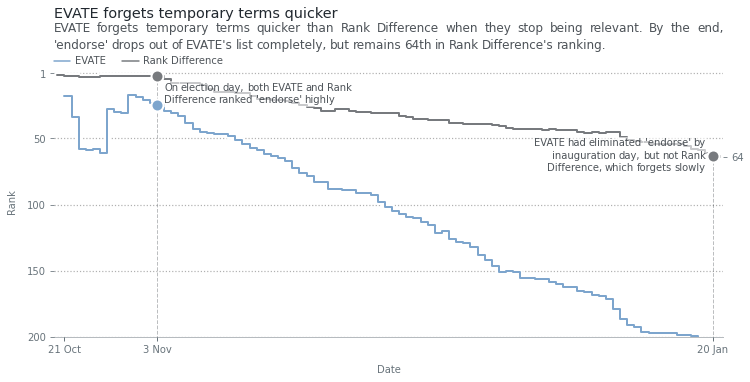

In [17]:
# update the style
style.update({ 'linewidth': 2 })
marker_style.update({ 'markersize': 10 })
annotation_marker_style.update({ 'markersize': 12, 'markeredgewidth': 2, 'markeredgecolor': 'C4' })

# prepare the data
methods = { 'ef-idf-entropy': 'EVATE',
            'rank-nva': 'Rank Difference' }
term = 'endors'
colors = { 'ef-idf-entropy': 'C1',
           'rank-nva': 'C3',
           'tf-idf-nva': 'C5' }

# draw the visualization
figure = plt.figure(figsize=(12, 5))
viz = drawable.Drawable(figure)

for method in methods:
    _xy = sorted(y[method][term].items(), key=lambda xy: xy[0])
    _x, _y = zip(*_xy)
    viz.draw_time_series(_x, _y, methods[method], color=colors[method],
                         drawstyle='steps-post', **style)

# draw the annotations
ylim = viz.get_ylim()

x = events['election']
_y = y['ef-idf-entropy'][term][x]
xpos = (x + 1, x + 30)
viz.vlines(x, ymin=min(_y, y['rank-nva'][term][x]), ymax=ylim[1], **line_style)
viz.plot(x, _y, color='C1', **annotation_marker_style)
viz.plot(x, y['rank-nva'][term][x], color='C3', **annotation_marker_style)
_annotation_style['align'], _annotation_style['va'] = 'left', 'bottom'
viz.annotate("On election day, both EVATE and Rank Difference ranked 'endorse' highly",
             xpos, _y, **_annotation_style)

x = events['inauguration']
_y = y['rank-nva'][term][x]
xpos = (x - 30, x - 1)
viz.vlines(x, ymin=min(_y, y['rank-nva'][term][x]), ymax=ylim[1], **line_style)
viz.plot(x, _y, color='C1', **annotation_marker_style)
viz.plot(x, y['rank-nva'][term][x], color='C3', **annotation_marker_style)
_annotation_style['align'], _annotation_style['va'] = 'right', 'center'
viz.annotate("EVATE had eliminated 'endorse' by inauguration day, but not Rank Difference, which forgets slowly",
             xpos, _y, **_annotation_style)
    
# finalize the visualization
viz.set_xlim(0.5, max(_x) + 0.5)
first_day = sorted(day for day, ranking in y['ef-idf-entropy'][term].items() if ranking <= 200)[0]
xticks = list(set([ events['election'], events['inauguration'], first_day ]))
viz.set_xticks(xticks)
viz.set_xticklabels([ re.sub('^0', '', dates[i - 1].strftime("%d %b")) for i in xticks ])
viz.set_ylim((-5, 200))
viz.set_yticks(list(set([ 1 ] + list(range(50, 201, 50)))))
viz.set_xlabel('Date')
viz.set_ylabel('Rank')
viz.invert_yaxis()
viz.set_axisbelow(True)

# add the labels at the end
ax2 = viz.axes.twinx()
ax2.set_yticks([ y[method][term][max(y[method][term])] for method in methods ])
ax2.set_ylim(viz.get_ylim())
ax2.grid(False)
viz.set_title("EVATE forgets temporary terms quicker", loc='left')
viz.set_caption(f"""EVATE forgets temporary terms quicker than Rank Difference when they stop being relevant.
                    By the end, '{ unstemmed.get(term, term) }' drops out of EVATE's list completely, but remains { list(y['rank-nva'][term].values())[-1] }th in Rank Difference's ranking.""",
                align='justify')
viz.savefig('../exports/4.4-ranking-endorse.png', dpi=300, bbox_inches='tight')

### Learning habits: differences between EF-ICF-Entropy and Rank Difference

Another difference between the two algorithms is that EF-ICF-Entropy tends to learn terms when they become relevant.
The term *veto*, for example, appears in Rank Difference's lexicon early in December as rumors increased about whether he would veto or sign a defense bill.
In EF-ICF-Entropy, the term appeared later and rose sharply after [Trump vetoed the defense bill](https://www.cnbc.com/2020/12/23/trump-vetoes-740-billion-ndaa-defense-bill.html) and when [Congress overrode that veto](https://www.bbc.com/news/world-us-canada-55510151).

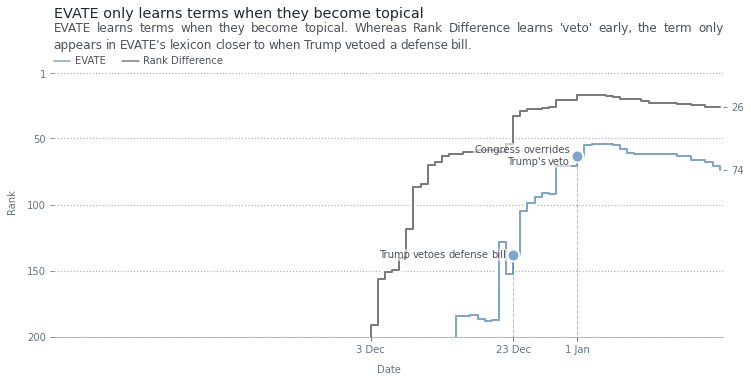

In [18]:
term, unstemmed = 'veto', 'veto'

# prepare the data
_annotations = {
    65: 'Trump vetoes defense bill',
    74: 'Congress overrides Trump\'s veto'
}

# draw the visualization
figure = plt.figure(figsize=(12, 5))
viz = drawable.Drawable(figure)

for method in methods:
    _xy = sorted(y[method][term].items(), key=lambda xy: xy[0])
    _x, _y = zip(*_xy)
    viz.draw_time_series(_x, _y, methods[method], drawstyle='steps-post', color=colors[method], **style)

# draw the annotations
ylim = viz.get_ylim()
for x, label in _annotations.items():
    _y = y['ef-idf-entropy'][term][x]
    viz.vlines(x, ymin=_y, ymax=ylim[1], **line_style)
    viz.plot(x, _y, color='C1', **annotation_marker_style)
    viz.annotate(label, (x - 20, x - 1), _y, **annotation_style)

# finalize the visualization
viz.set_xlim(0.5, max(_x) + 0.5)
xticks = list(set([ 1 ] + list(range(7, df.events.max() + 1, 7))))
xticks = list(_annotations) + [ sorted(day for day, ranking in y['rank-nva'][term].items()
                                           if ranking <= 200)[0] ]
viz.set_xticks(xticks)
viz.set_xticklabels([ re.sub('^0', '', dates[i - 1].strftime("%d %b")) for i in xticks ])
viz.set_ylim((-5, 200))
viz.set_yticks(list(set([ 1 ] + list(range(50, 201, 50)))))
viz.set_xlabel('Date')
viz.set_ylabel('Rank')
viz.invert_yaxis()
viz.set_axisbelow(True)

# add the labels at the end
ax2 = viz.axes.twinx()
ax2.set_yticks([ y[method][term][max(y[method][term])] for method in methods ])
ax2.set_ylim(viz.get_ylim())
ax2.grid(False)
viz.set_title("EVATE only learns terms when they become topical", loc='left')
viz.set_caption(f"""EVATE learns terms when they become topical.
                    Whereas Rank Difference learns '{ unstemmed }' early, the term only appears in EVATE's lexicon closer to when Trump vetoed a defense bill.""",
                align='justify')
viz.savefig('../exports/4.4-ranking-veto.png', dpi=300, bbox_inches='tight')

Similarly, Rank Difference introduced the term *inauguration* to its ranking very early, as soon as networks called the election for Biden, around November 7, 2020.
EF-ICF-Entropy waited longer and only added *inauguration* to its ranking a fortnight before the actual Inauguration Day.

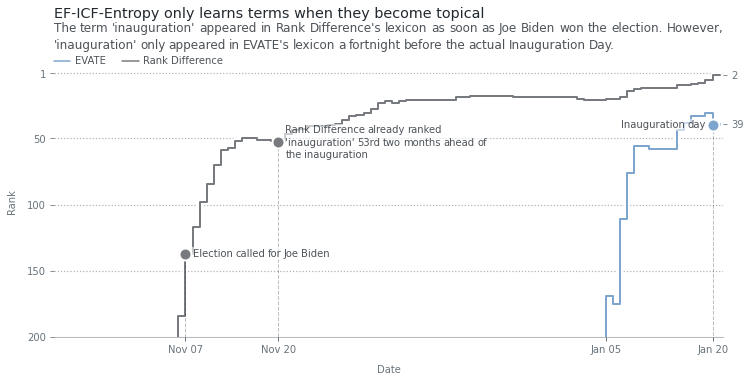

In [19]:
term, unstemmed = 'inaugur', 'inauguration'

# prepare the data
methods = { 'ef-idf-entropy': 'EVATE',
            'rank-nva': 'Rank Difference' }
_annotations = {
    events['inauguration']: {
        'text': annotations[events['inauguration']],
        'style': { 'align': 'right' }
    },
    events['call']: {
        'text': annotations[events['call']],
        'style': { 'align': 'left' }
    },
    events['call'] + 13: {
        'text': f"""Rank Difference already ranked 'inauguration' { y['rank-nva'][term][events['call'] + 13] }rd 
                    two months ahead of the inauguration""",
        'style': { 'align': 'left' }
    }
}

# draw the visualization
figure = plt.figure(figsize=(12, 5))
viz = drawable.Drawable(figure)

for method in methods:
    _xy = sorted(y[method][term].items(), key=lambda xy: xy[0])
    _x, _y = zip(*_xy)
    viz.draw_time_series(_x, _y, methods[method], drawstyle='steps-post', color=colors[method], **style)

# draw the annotations
ylim = viz.get_ylim()
for x, annotation in _annotations.items():
    _y = y['ef-idf-entropy'][term][x] if y['ef-idf-entropy'][term][x] <= 200 else y['rank-nva'][term][x]
    color = 'C1' if y['ef-idf-entropy'][term][x] <= 200 else 'C3'
    viz.vlines(x, ymin=_y, ymax=ylim[1], **line_style)
    viz.plot(x, _y, color=color, **annotation_marker_style)
    _annotation_style = dict(annotation_style)
    _annotation_style.update(annotation['style'])
    xpos = (x - 30, x - 1) if annotation['style']['align'] == 'right' else (x + 1, x + 30)
    viz.annotate(annotation['text'], xpos, _y, **_annotation_style)

# finalize the visualization
viz.set_xlim(0.5, max(_x) + 0.5)
first_day = sorted(day for day, ranking in y['ef-idf-entropy'][term].items() if ranking <= 200)[0]
xticks = list(set(list(_annotations.keys()) + [ first_day ]))
viz.set_xticks(xticks)
viz.set_xticklabels([ re.sub('^0', '', dates[i - 1].strftime("%b %d")) for i in xticks ])
viz.set_ylim((-5, 200))
viz.set_yticks(list(set([ 1 ] + list(range(50, 201, 50)))))
viz.set_xlabel('Date')
viz.set_ylabel('Rank')
viz.invert_yaxis()
viz.set_axisbelow(True)

# add the labels at the end
ax2 = viz.axes.twinx()
ax2.set_yticks([ y[method][term][max(y[method][term])] for method in methods ])
ax2.set_ylim(viz.get_ylim())
ax2.grid(False)
viz.set_title("EF-ICF-Entropy only learns terms when they become topical", loc='left')
viz.set_caption(f"""The term '{ unstemmed }' appeared in Rank Difference's lexicon as soon as Joe Biden won the election.
                    However, '{ unstemmed }' only appeared in EVATE's lexicon a fortnight before the actual Inauguration Day.""",
                align='justify')
viz.savefig('../exports/4.4-ranking-inauguration.png', dpi=300, bbox_inches='tight')

There are some things that Rank Difference does much better than EF-ICF-Entropy.
Rank Difference captures momentous events, such as the *insurrection* easily because it is highly specific.
EF-ICF-Entropy, however, waits to observe *insurrection* as a topical keywords several times before capturing it—which never happens.

**Conclusion:** Rank Difference learns big news better than EF-ICF-Entropy, even if ephemeral.

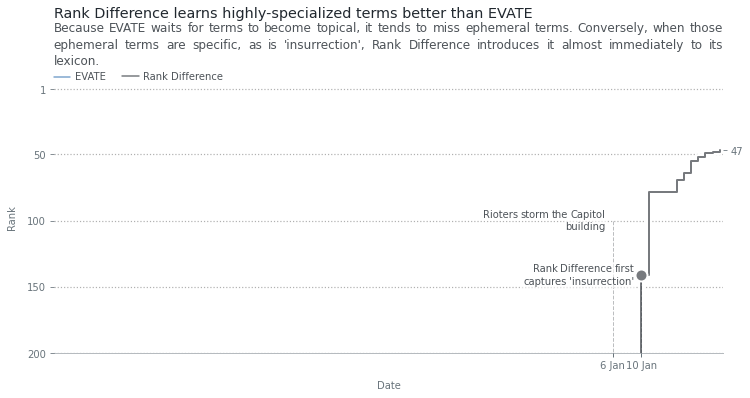

In [20]:
term, unstemmed = 'insurrect', 'insurrection'

# prepare the data
appears = sorted([ x for x in y['rank-nva'][term] if y['rank-nva'][term][x] < 200])
_annotations = {
    79: "Rioters storm the Capitol building",
    appears[0]: f"Rank Difference first captures '{ unstemmed }'"
}
# draw the visualization
figure = plt.figure(figsize=(12, 5))
viz = drawable.Drawable(figure)

for method in methods:
    _xy = sorted(y[method][term].items(), key=lambda xy: xy[0])
    _x, _y = zip(*_xy)
    viz.draw_time_series(_x, _y, methods[method], drawstyle='steps-post', color=colors[method], **style)

# draw the annotations
ylim = viz.get_ylim()
for x, label in _annotations.items():
    _y = y['rank-nva'][term][x] if y['rank-nva'][term][x] < 200 else 100
    viz.vlines(x, ymin=_y, ymax=ylim[1], **line_style)
    viz.plot(x, _y, color='C3', **annotation_marker_style) if y['rank-nva'][term][x] < 200 else None
    viz.annotate(label, (x - 20, x - 1), _y, **annotation_style)

# finalize the visualization
viz.set_xlim(0.5, max(_x) + 0.5)
xticks = list(set([ 1 ] + list(range(7, df.events.max() + 1, 7))))
xticks = list(_annotations)
viz.set_xticks(xticks)
viz.set_xticklabels([ re.sub('^0', '', dates[i - 1].strftime("%d %b")) for i in xticks ])
viz.set_ylim((-5, 200))
viz.set_yticks(list(set([ 1 ] + list(range(50, 201, 50)))))
viz.set_xlabel('Date')
viz.set_ylabel('Rank')
viz.invert_yaxis()
viz.set_axisbelow(True)

# add the labels at the end
ax2 = viz.axes.twinx()
ax2.set_yticks([ y[method][term][max(y[method][term])] for method in y ])
ax2.set_ylim(viz.get_ylim())
ax2.grid(False)
viz.set_title("Rank Difference learns highly-specialized terms better than EVATE", loc='left')
viz.set_caption(f"""Because EVATE waits for terms to become topical, it tends to miss ephemeral terms.
                    Conversely, when those ephemeral terms are specific, as is '{ unstemmed }', Rank Difference introduces it almost immediately to its lexicon.""",
                align='justify')
viz.savefig('../exports/4.4-ranking-insurrection.png', dpi=300, bbox_inches='tight')

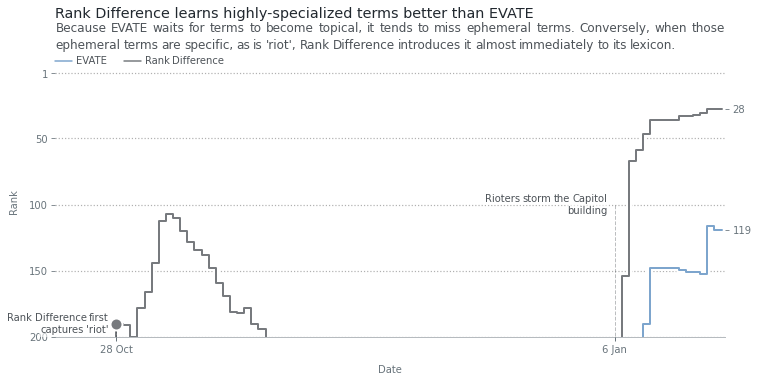

In [21]:
term, unstemmed = 'riot', 'riot'

# prepare the data
appears = sorted([ x for x in y['rank-nva'][term] if y['rank-nva'][term][x] < 200])
_annotations = {
    79: "Rioters storm the Capitol building",
    appears[0]: f"Rank Difference first captures '{ unstemmed }'"
}
# draw the visualization
figure = plt.figure(figsize=(12, 5))
viz = drawable.Drawable(figure)

for method in methods:
    _xy = sorted(y[method][term].items(), key=lambda xy: xy[0])
    _x, _y = zip(*_xy)
#     print(list(zip(_x, _y)))
    viz.draw_time_series(_x, _y, methods[method], drawstyle='steps-post', color=colors[method], **style)

# draw the annotations
ylim = viz.get_ylim()
for x, label in _annotations.items():
    _y = y['rank-nva'][term][x] if y['rank-nva'][term][x] < 200 else 100
    viz.vlines(x, ymin=_y, ymax=ylim[1], **line_style)
    viz.plot(x, _y, color='C3', **annotation_marker_style) if y['rank-nva'][term][x] < 200 else None
    viz.annotate(label, (x - 20, x - 1), _y, **annotation_style)

# finalize the visualization
viz.set_xlim(0.5, max(_x) + 0.5)
xticks = list(set([ 1 ] + list(range(7, df.events.max() + 1, 7))))
xticks = list(_annotations)
viz.set_xticks(xticks)
viz.set_xticklabels([ re.sub('^0', '', dates[i - 1].strftime("%d %b")) for i in xticks ])
viz.set_ylim((-5, 200))
viz.set_yticks(list(set([ 1 ] + list(range(50, 201, 50)))))
viz.set_xlabel('Date')
viz.set_ylabel('Rank')
viz.invert_yaxis()
viz.set_axisbelow(True)

# add the labels at the end
ax2 = viz.axes.twinx()
ax2.set_yticks([ y[method][term][max(y[method][term])] for method in y ])
ax2.set_ylim(viz.get_ylim())
ax2.grid(False)
viz.set_title("Rank Difference learns highly-specialized terms better than EVATE", loc='left')
viz.set_caption(f"""Because EVATE waits for terms to become topical, it tends to miss ephemeral terms.
                    Conversely, when those ephemeral terms are specific, as is '{ unstemmed }', Rank Difference introduces it almost immediately to its lexicon.""",
                align='justify')
viz.savefig('../exports/4.4-ranking-riot.png', dpi=300, bbox_inches='tight')

### EF-ICF-Entropy learns general terms, Rank Difference doesn't (or some familiar patterns, after all)

Rank Difference is built on the concept of specificity, which works out quite well for it.
It does mean, however, that is struggles to capture the more general terms.
In fact, Rank Difference captures neither _vote_, nor _presid[ent]_, nor even _elect_.
It misses all of these terms because they're popular terms (especially when the general corpus was collected) in general.
As a result, terms that were even more specific overtook these more general words.
Conversely, TF-ICF captures them because it is not a corpus-comparison approach.

To illustrate better how Rank Difference mostly focuses on the big terms, consider the next visualization, which shows how EF-ICF-Entropy learns the relatively-new term _stimulu[s]_, even two months in.
In contrast, Rank Difference doesn't capture this term because it had already been popular in the general corpus.

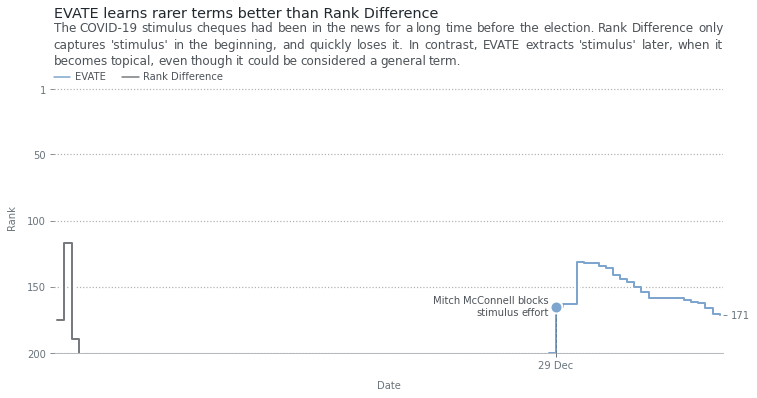

In [22]:
term, unstemmed = 'stimulu', 'stimulus'

# prepare the data
_annotations = {
    71: 'Mitch McConnell blocks stimulus effort', # https://www.theguardian.com/world/2020/dec/29/mitch-mcconnell-blocks-trump-push-covid-stimulus-checks-2000
}

methods = { 'ef-idf-entropy': 'EVATE',
            'rank-nva': 'Rank Difference' }

# draw the visualization
figure = plt.figure(figsize=(12, 5))
viz = drawable.Drawable(figure)

for method in methods:
    _xy = sorted(y[method][term].items(), key=lambda xy: xy[0])
    _x, _y = zip(*_xy)
    viz.draw_time_series(_x, _y, methods[method], drawstyle='steps-post', color=colors[method], **style)

# draw the annotations
ylim = viz.get_ylim()
for x, label in _annotations.items():
    _y = y['ef-idf-entropy'][term][x]
    viz.vlines(x, ymin=_y, ymax=ylim[1], **line_style)
    viz.plot(x, _y, color='C1', **annotation_marker_style)
    viz.annotate(label, (x - 20, x - 1), _y, **annotation_style)

# finalize the visualization
viz.set_xlim(0.5, max(_x) + 0.5)
xticks = list(set([ 1 ] + list(range(7, df.events.max() + 1, 7))))
xticks = list(_annotations)
viz.set_xticks(xticks)
viz.set_xticklabels([ re.sub('^0', '', dates[i - 1].strftime("%d %b")) for i in xticks ])
viz.set_ylim((-5, 200))
viz.set_yticks(list(set([ 1 ] + list(range(50, 201, 50)))))
viz.set_xlabel('Date')
viz.set_ylabel('Rank')
viz.invert_yaxis()
viz.set_axisbelow(True)

# add the labels at the end
ax2 = viz.axes.twinx()
ax2.set_yticks([ y[method][term][max(y[method][term])] for method in methods ])
ax2.set_ylim(viz.get_ylim())
ax2.grid(False)
viz.set_title("EVATE learns rarer terms better than Rank Difference", loc='left')
viz.set_caption(f"""The COVID-19 stimulus cheques had been in the news for a long time before the election.
                    Rank Difference only captures '{ unstemmed }' in the beginning, and quickly loses it.
                    In contrast, EVATE extracts '{ unstemmed }' later, when it becomes topical, even though it could be considered a general term.""",
                align='justify')
viz.savefig('../exports/4.4-ranking-stimulus.png', dpi=300, bbox_inches='tight')

TF-ICF handled general terms much better than Rank Difference.
Like EF-ICF-Entropy, the term *election*, a staple in our dataset, appears early in TF-ICF's ranking and never quits.
In contrast, *election* appears only briefly in Rank Difference.

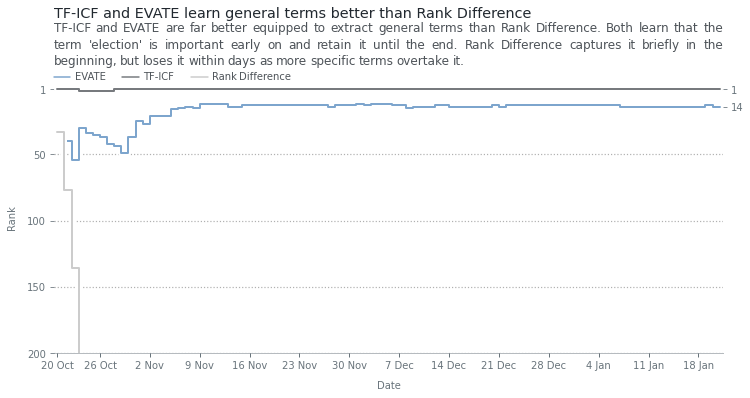

In [23]:
# prepare the data
term, unstemmed = 'elect', 'election'
methods = { 'ef-idf-entropy': 'EVATE',
            'tf-idf-nva': 'TF-ICF',
            'rank-nva': 'Rank Difference' }

linestyle = { 'ef-idf-entropy': '-',
              'tf-idf-nva': '-',
              'rank-nva': '-' }
colors = { 'ef-idf-entropy': 'C1',
           'rank-nva': 'C5',
           'tf-idf-nva': 'C3' }

# draw the visualization
figure = plt.figure(figsize=(12, 5))
viz = drawable.Drawable(figure)

for method in methods:
    _xy = sorted(y[method][term].items(), key=lambda xy: xy[0])
    _x, _y = zip(*_xy)
    viz.draw_time_series(_x, _y, methods[method], drawstyle='steps-post', linestyle=linestyle[method], color=colors[method], **style)

# finalize the visualization
viz.set_xlim(0.5, max(_x) + 0.5)
xticks = list(set([ 1 ] + list(range(7, df.events.max() + 1, 7))))
# xticks = list(_annotations)
viz.set_xticks(xticks)
viz.set_xticklabels([ re.sub('^0', '', dates[i - 1].strftime("%d %b")) for i in xticks ])
viz.set_ylim((-5, 200))
viz.set_yticks(list(set([ 1 ] + list(range(50, 201, 50)))))
viz.set_xlabel('Date')
viz.set_ylabel('Rank')
viz.invert_yaxis()
viz.set_axisbelow(True)

# add the labels at the end
ax2 = viz.axes.twinx()
ax2.set_yticks([ y[method][term][max(y[method][term])] for method in methods ])
ax2.set_ylim(viz.get_ylim())
ax2.grid(False)
viz.set_title("TF-ICF and EVATE learn general terms better than Rank Difference", loc='left')
viz.set_caption(f"""TF-ICF and EVATE are far better equipped to extract general terms than Rank Difference.
                    Both learn that the term '{ unstemmed }' is important early on and retain it until the end.
                    Rank Difference captures it briefly in the beginning, but loses it within days as more specific terms overtake it.""",
                align='justify')
viz.savefig('../exports/4.4-ranking-election.png', dpi=300, bbox_inches='tight')

The thing about politics is that not every policy is political.
The vaccination drive is a great example: it's detached from politics, but it became an important political topic nevertheless.
Rank Difference did not capture _vaccin[e]_ either, but TF-ICF and EF-ICF-Entropy did.

Still, similarly to before, EF-ICF-Entropy learns faster than TF-ICF because the logarithmic EF makes it easier for newly-important terms to catch up with older terms.

**Conclusion:** EF-ICF-Entropy learns general terms faster than TF-ICF.

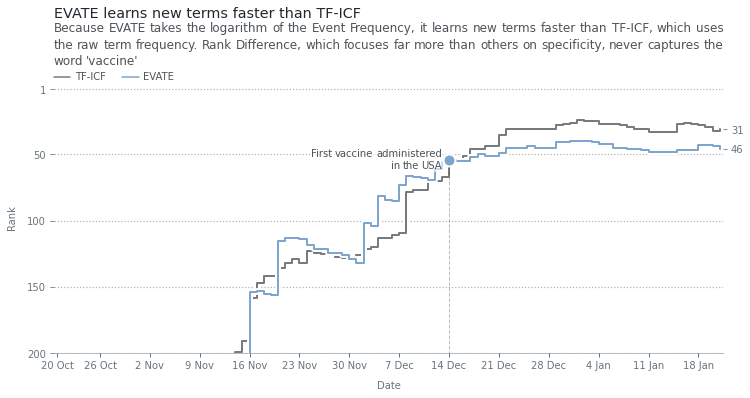

In [24]:
term, unstemmed = 'vaccin', 'vaccine'

methods = { 'tf-idf-nva': 'TF-ICF',
            'ef-idf-entropy': 'EVATE' }

# prepare the data
_annotations = {
    56: 'First vaccine administered in the USA', # https://www.bbc.com/news/world-us-canada-55305720
}

# draw the visualization
figure = plt.figure(figsize=(12, 5))
viz = drawable.Drawable(figure)

for method in methods:
    _xy = sorted(y[method][term].items(), key=lambda xy: xy[0])
    _x, _y = zip(*_xy)
    viz.draw_time_series(_x, _y, methods[method], drawstyle='steps-post', color=colors[method], **style)

# draw the annotations
ylim = viz.get_ylim()
for x, label in _annotations.items():
    _y = y['ef-idf-entropy'][term][x]
    viz.vlines(x, ymin=_y, ymax=ylim[1], **line_style)
    viz.plot(x, _y, color='C1', **annotation_marker_style)
    viz.annotate(label, (x - 20, x - 1), _y, **annotation_style)

# finalize the visualization
viz.set_xlim(0.5, max(_x) + 0.5)
xticks = list(set([ 1 ] + list(range(7, df.events.max() + 1, 7))))
# xticks = list(_annotations)
viz.set_xticks(xticks)
viz.set_xticklabels([ re.sub('^0', '', dates[i - 1].strftime("%d %b")) for i in xticks ])
viz.set_ylim((-5, 200))
viz.set_yticks(list(set([ 1 ] + list(range(50, 201, 50)))))
viz.set_xlabel('Date')
viz.set_ylabel('Rank')
viz.invert_yaxis()
viz.set_axisbelow(True)

# add the labels at the end
ax2 = viz.axes.twinx()
ax2.set_yticks([ y[method][term][max(y[method][term])] for method in y ])
ax2.set_ylim(viz.get_ylim())
ax2.grid(False)
viz.set_title("EVATE learns new terms faster than TF-ICF", loc='left')
viz.set_caption(f"""Because EVATE takes the logarithm of the Event Frequency, it learns new terms faster than TF-ICF, which uses the raw term frequency.
                    Rank Difference, which focuses far more than others on specificity, never captures the word '{ unstemmed }'""",
                align='justify')
viz.savefig('../exports/4.4-ranking-vaccine.png', dpi=300, bbox_inches='tight')

Like Rank Difference, TF-ICF also forgets slowly.
The term *ballot* is always present in TF-ICF's lexicon, and ends ranked 67$^{th}$.
In EF-ICF-Entropy's list, ballot only rose during the election cycle, and drops after Joe Biden won the election.

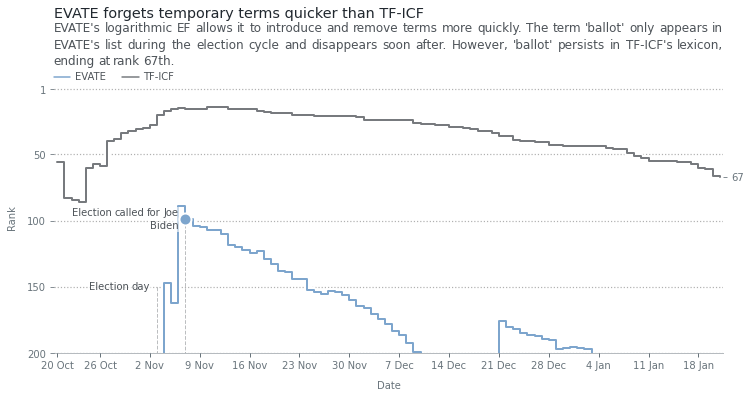

In [25]:
term, unstemmed = 'ballot', 'ballot'

methods = { 'ef-idf-entropy': 'EVATE',
            'tf-idf-nva': 'TF-ICF' }

_annotations = {
    events['election']: "Election day",
    events['call']: "Election called for Joe Biden",
}
    
# draw the visualization
figure = plt.figure(figsize=(12, 5))
viz = drawable.Drawable(figure)

for method in methods:
    _xy = sorted(y[method][term].items(), key=lambda xy: xy[0])
    _x, _y = zip(*_xy)
    viz.draw_time_series(_x, _y, methods[method], drawstyle='steps-post', linestyle=linestyle[method], color=colors[method], **style)

# draw the annotations
ylim = viz.get_ylim()
for x, label in _annotations.items():
    _y = y['ef-idf-entropy'][term][x] if y['ef-idf-entropy'][term][x] <= 200 else 150
    viz.vlines(x, ymin=_y, ymax=ylim[1], **line_style)
    if y['ef-idf-entropy'][term][x] <= 200:
        viz.plot(x, _y, color='C1', **annotation_marker_style)
    viz.annotate(label, (x-20, x -1), _y, **annotation_style)

# finalize the visualization
viz.set_xlim(0.5, max(_x) + 0.5)
xticks = list(set([ 1 ] + list(range(7, df.events.max() + 1, 7))))
# xticks = list(_annotations)
viz.set_xticks(xticks)
viz.set_xticklabels([ re.sub('^0', '', dates[i - 1].strftime("%d %b")) for i in xticks ])
viz.set_ylim((-5, 200))
viz.set_yticks(list(set([ 1 ] + list(range(50, 201, 50)))))
viz.set_xlabel('Date')
viz.set_ylabel('Rank')
viz.invert_yaxis()
viz.set_axisbelow(True)

# add the labels at the end
ax2 = viz.axes.twinx()
ax2.set_yticks([ y[method][term][max(y[method][term])] for method in y ])
ax2.set_ylim(viz.get_ylim())
ax2.grid(False)
viz.set_title("EVATE forgets temporary terms quicker than TF-ICF", loc='left')
viz.set_caption(f"""EVATE's logarithmic EF allows it to introduce and remove terms more quickly.
                    The term '{ unstemmed }' only appears in EVATE's list during the election cycle and disappears soon after.
                    However, '{ unstemmed }' persists in TF-ICF's lexicon, ending at rank { list(y['tf-idf-nva'][term].values())[-1] }th.""",
                align='justify')
viz.savefig('../exports/4.4-ranking-ballot.png', dpi=300, bbox_inches='tight')

This leads us to two conclusions.
First, some habits are hard to break: Rank Difference still prefers specific terms, in spite of its good performance.
Elections happen to be a domain with many technical domains, which masks Rank Difference's struggles.

**Conclusion:** Rank Difference struggles far more than TF-ICF and EF-ICF-Entropy with non-technical terms.

The second conclusion is, in a way, a generalization of the previous one.
TF-ICF also remains stuck with the general terms.
EF-ICF-Entropy is somewhere in-between, capturing both general terms and specific terms.

**Conclusion:** EF-ICF-Entropy takes a little bit from TF-ICF to learn the general terms, and a little bit from Rank Difference to learn more specific, but only topical terms.

**Conclusion:** EF-ICF-Entropy adapts better than TF-ICF and Rank Difference since it does not rely on term frequency, but it depends on terms being topical in several events to rank them highly.